In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',200)



In [2]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [12.0,8.0]

In [3]:
df_train = pd.read_csv("../data/palabras.csv")

In [4]:
df_train['fecha'] = pd.to_datetime(df_train['fecha'], errors='coerce').values.astype(int) / 10**9

In [5]:
def fill_m2(df):
    df['metrostotales'].fillna(df['metroscubiertos'], inplace=True)
    df['metroscubiertos'].fillna(df['metrostotales'], inplace=True)
    
    return df

In [6]:
df_train

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,anio,mes,dia,amenities,iluminada,funcional,discreta,inversion,moderno,calentador,hermosa,excelente,mejor,grande,equipada,vestidor,credito,privada,bodega,club,cerrada,jardin,oportunidad,tv,juegos,niño,transporte,estudio,terraza,balcon,lote,fraccionamiento,local,seguridad,garage,centro,techada,estancia,alberca,servicios,servicio,estilo,frente,vista,visitas,parque,areas,estrenar,infonavit,residencial,escuela,exclusivo,lujo,esquina,refaccion,country,barra,lavado,renta,super,lago,bosque,avenida,hospital,pileta,solarium,gas
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,NaN,2.0,1.0,2.0,80.0,80.0,23533.0,0.373424,0.0,0.0,0.0,0.0,0.0,2273000.0,2015,8,23,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
1,53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",Casa en condominio,AV. MEXICO,La Magdalena Contreras,Distrito Federal,10.0,3.0,2.0,2.0,268.0,180.0,24514.0,-0.239862,0.0,0.0,0.0,1.0,1.0,3600000.0,2013,6,28,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,247984,casa en venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,Casa,Urbi Tonala,Tonalá,Jalisco,5.0,3.0,2.0,2.0,144.0,166.0,48551.0,1.312489,0.0,0.0,0.0,0.0,0.0,1200000.0,2015,10,17,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,209067,casa sola en toluca zinacantepec con credito i...,casa en privada con caseta de vigilancia casas...,Casa,IGNACIO MANUEL ALTAMIRANO 128,Zinacantepec,Edo. de México,1.0,2.0,1.0,1.0,63.0,67.0,53666.0,-1.026556,0.0,0.0,0.0,1.0,1.0,650000.0,2012,3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,185997,paseos del sol,bonito departamento en excelentes condiciones ...,Apartamento,PASEOS DEL SOL,Zapopan,Jalisco,10.0,2.0,1.0,1.0,95.0,95.0,47835.0,0.544276,0.0,0.0,0.0,0.0,0.0,1150000.0,2016,6,7,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239995,119879,bonita casas de 2 recamaras a 10 minutos del c...,vendo casa en bosques de ica residencial a 10 ...,Casa,BOSQUES,Zinacantepec,Edo. de México,0.0,2.0,2.0,1.0,67.0,NaN,53666.0,-0.708444,0.0,0.0,0.0,0.0,0.0,650000.0,2015,2,8,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
239996,259178,casa en condominio a 10 min. del centro de toluca,"casa con un jardin amplio, un cuarto de servic...",Casa,Filiberto Navas 325,Toluca,Edo. de México,0.0,3.0,3.0,3.0,200.0,250.0,51954.0,-0.284492,0.0,0.0,0.0,1.0,1.0,1940000.0,2014,7,10,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
239997,131932,nicolas san juan,"departamento con excelente ubicación, muy cerc...",Apartamento,Nicolas San Juan,Benito Juárez,Distrito Federal,20.0,2.0,1.0,2.0,138.0,138.0,50003995.0,-0.471925,0.0,0.0,0.0,0.0,0.0,3400000.0,2015,3,3,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,

## Pre-processing

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [8]:
def getDropCols():
    return ['titulo', 'descripcion', 'direccion', 'id', 'dia', 'mes'] # temporal

def getOneHotCols():
    return ['tipodepropiedad', 'provincia']

def getBinaryCols():
    return ['ciudad', 'idzona']

In [9]:
def preprocess(df, OHE, BE, encodingType):
    features = df.copy()
    drop_cols = getDropCols()
    features = features.drop(drop_cols, axis=1)

    if (encodingType == 'train'):
        features = OHE.fit_transform(features)
        features = BE.fit_transform(features)
    else:
        features = OHE.transform(features)
        features = BE.transform(features)
        
    drop_cols = getOneHotCols()
    drop_cols.extend(getBinaryCols())

    display(drop_cols)
                
    #features = features.drop(drop_cols, axis=1)
    
    features = fill_m2(features)
    
    features_with_nans = features.columns[features.isna().any()].tolist()
    
    for feature in features_with_nans:
        features[feature] = features[feature].fillna(0)
        
    #imp = Imputer()
    #imp_cols = ['antiguedad', 'banos', 'habitaciones', 'garages']
    #X_train[imp_cols] = imp.fit_transform(X_train[imp_cols])
        
    return features    

In [10]:
import category_encoders as ce

OHE = ce.OneHotEncoder(cols=getOneHotCols(), handle_unknown='ignore', use_cat_names=True)
BE = ce.BinaryEncoder(cols=getBinaryCols(), handle_unknown='ignore')

In [11]:
X = df_train.drop("precio", axis=1)
y = df_train['precio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [12]:
X_train_submit = X_train.copy()

In [13]:
X_train = preprocess(X_train, OHE, BE, 'train')
X_test = preprocess(X_test, OHE, BE, 'test')

['tipodepropiedad', 'provincia', 'ciudad', 'idzona']

['tipodepropiedad', 'provincia', 'ciudad', 'idzona']

In [14]:
print(f"Original shapes: X={X.shape} y={y.shape}")
print(f"Train shapes: X={X_train.shape} y={y_train.shape}")
print(f"Test  shapes: X={X_test.shape}  y={y_test.shape}")

Original shapes: X=(240000, 87) y=(240000,)
Train shapes: X=(180000, 161) y=(180000,)
Test  shapes: X=(60000, 161)  y=(60000,)


## Feature Selection

In [15]:
#from sklearn.feature_selection import SelectKBest

In [16]:
#selection = SelectKBest(k=40)
#x_features = selection.fit_transform(X_train, y_train)
#columns = np.asarray(X_train.columns.values)
#support = np.asarray(selection.get_support())
#columns_with_support = columns[support]

In [17]:
#columns_with_support

## Training

In [18]:
from xgboost import XGBRegressor

model = XGBRegressor(learning_rate=0.1,n_estimators=1750,n_jobs=6,subsample= 0.7, colsample_bytree= 1.0,objective="reg:squarederror",max_depth= 11, min_child_weight= 1,eval_metric="rmse")


In [19]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, eval_metric='rmse',
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
             n_estimators=1750, n_jobs=6, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.7, verbosity=1)

In [20]:
# Matriz de correlaciones como heatmap
#plt.figure(figsize=(15, 15))
#sns.heatmap(df_train.corr(), square=True, fmt='.2f');

## Predicciones

In [21]:
def predecir(model, train_features, train_labels, test_features, test_labels):
    predict = model.predict(test_features)
    print('Entrenamiento: {:0.4f}%'.format(model.score(train_features, train_labels)*100))
    
    if ~test_labels.empty:
        error = mean_absolute_error(test_labels, predict)
        score = model.score(test_features,test_labels)
        print('Testeo: {:0.4f}%.'.format(score*100))
        print('Mean abs error: {:0.4f}.'.format(error))
    
    return predict

In [22]:
predecir(model, X_train, y_train, X_test, y_test)

Entrenamiento: 99.9763%
Testeo: 82.3399%.
Mean abs error: 529806.8224.


array([3220587.5, 2408074. , 6815998.5, ..., 2021251. , 2487489.8,
       1295309.1], dtype=float32)

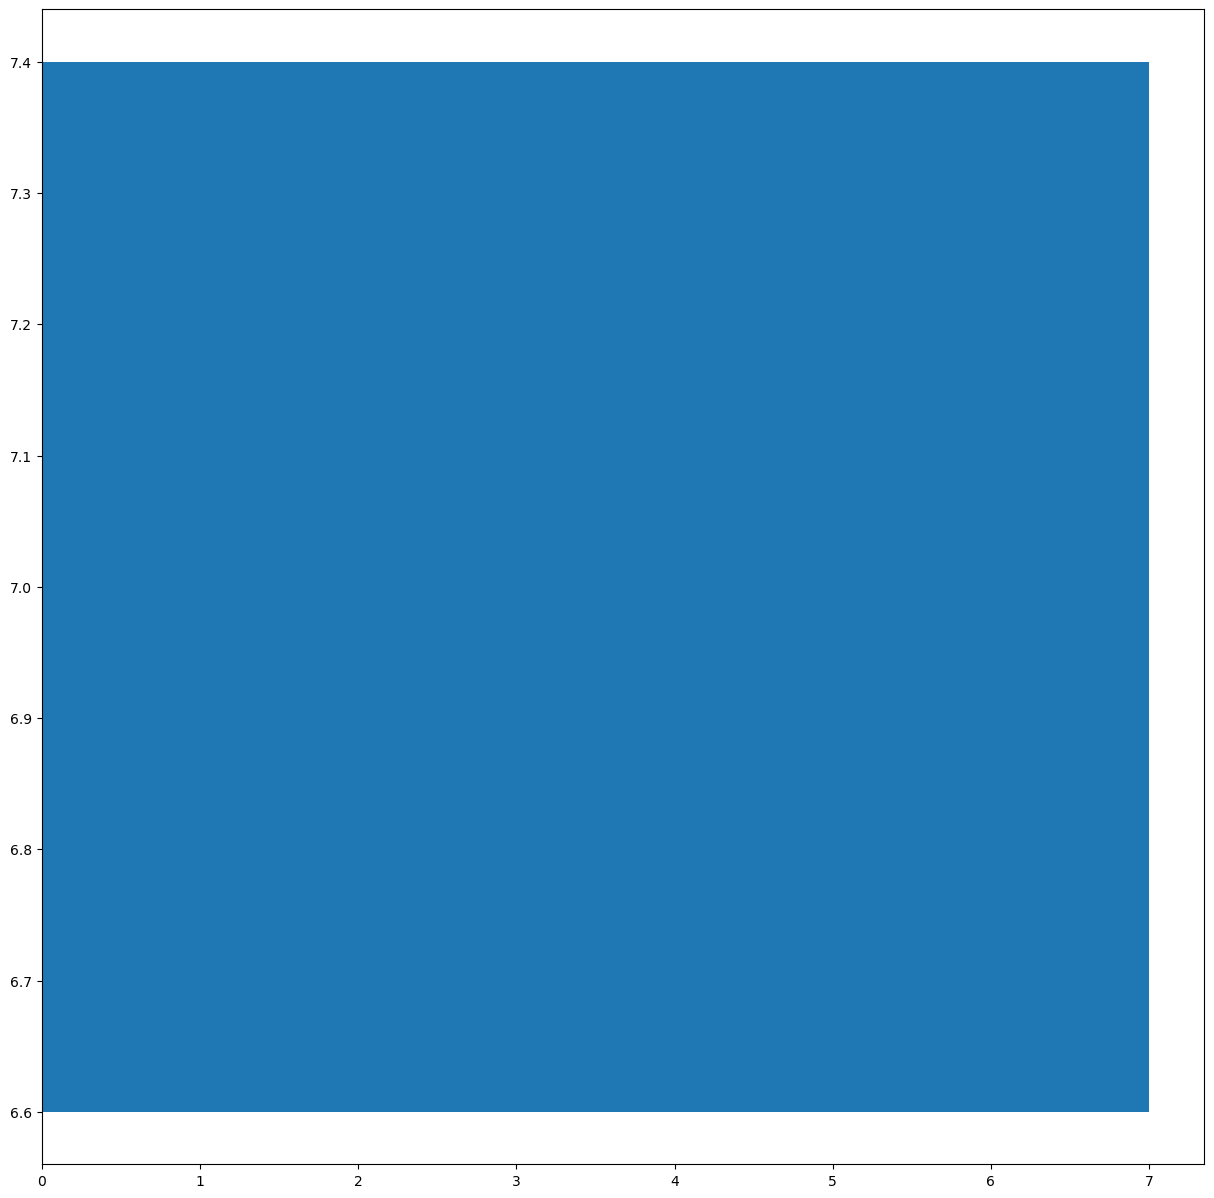

In [23]:
plt.rcParams["figure.figsize"] = [15, 15]

importancia = model.feature_importances_

d = {'x':X_train.columns,'y':importancia}

importancia = pd.DataFrame(d)
importancia = importancia[importancia.y>0.005].count()
ax = plt.barh(importancia.x,importancia.y)

 ## Tunning

In [21]:
from sklearn.model_selection import GridSearchCV
param_test1 = {
 #'n_estimators':range(500,3000,250)   
 #'learning_rate':range(0.001,0.15,0.01)
 'max_depth':range(5,21,3),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate = 0.1,n_estimators=500,subsample= 0.7, colsample_bytree= 1.0,objective="reg:squarederror",eval_metric="rmse"), 
                        param_grid = param_test1,
                        n_jobs=6,
                        cv=4,
                        verbose=10)

gsearch1.fit(X_train,y_train)

gsearch1.scorer_,gsearch1.best_params_, gsearch1.best_score_

Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed: 12.4min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed: 12.6min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed: 43.6min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed: 60.5min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed: 86.0min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 144.0min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed: 223.4min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed: 268.3min
[Parallel(n_jobs=6)]: Done  69 out of  72 | elapsed: 371.8min remaining: 16.2min
[Parallel(n_jobs=6)]: Done  72 out of  72 | elapsed: 373.3min finished


AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [22]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 11, 'min_child_weight': 1}, 0.8136997812379274)

In [23]:
predecir(gsearch1,X_train,y_train,X_test,y_test)

Entrenamiento: 98.2953%
Testeo: 82.1874%.
Mean abs error: 533814.0635.


array([3124949.5, 2341879.2, 6784460.5, ..., 2038165. , 2480032.2,
       1334487.8], dtype=float32)

In [24]:
best_grid = gsearch1.best_estimator_
predecir(best_grid,X_train,y_train,X_test,y_test)

Entrenamiento: 98.2953%
Testeo: 82.1874%.
Mean abs error: 533814.0635.


array([3124949.5, 2341879.2, 6784460.5, ..., 2038165. , 2480032.2,
       1334487.8], dtype=float32)

### Tuning n estimators

In [26]:
from sklearn.model_selection import GridSearchCV
param_test1 = {
 'n_estimators':range(500,3501,250)   
 #'learning_rate':range(0.001,0.15,0.01)
 #'max_depth':range(5,21,3),
# 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(scoring='roc_auc',learning_rate = 0.1,min_child_weight=1 ,max_depth = 11,subsample= 0.7, colsample_bytree= 1.0,objective="reg:squarederror",eval_metric="rmse"), 
                        param_grid = param_test1,
                        n_jobs=6,
                        cv=4,
                        verbose=10)

gsearch1.fit(X_train,y_train)

gsearch1.best_params_, gsearch1.best_score_

Fitting 4 folds for each of 13 candidates, totalling 52 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed: 26.2min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed: 39.4min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed: 135.5min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed: 220.8min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed: 386.8min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 577.3min
[Parallel(n_jobs=6)]: Done  47 out of  52 | elapsed: 896.4min remaining: 95.4min
[Parallel(n_jobs=6)]: Done  52 out of  52 | elapsed: 1029.9min finished


({'n_estimators': 1750}, 0.8145093055064185)

In [27]:
best_grid = gsearch1.best_estimator_
predecir(best_grid,X_train,y_train,X_test,y_test)

Entrenamiento: 99.9763%
Testeo: 82.3399%.
Mean abs error: 529806.8224.


array([3220587.5, 2408074. , 6815998.5, ..., 2021251. , 2487489.8,
       1295309.1], dtype=float32)

## Algo Grafico

In [23]:
def completar(df,precios):
    for fila in range(df.shape[0]):
        #print(fila)
        df.iloc[fila,1] = precios[fila]
    return df

def error(df):
    df["error"]=0
    for fila in range(df.shape[0]):
        df.iloc[fila,2] = round(abs(df.iloc[fila,1]- df.iloc[fila,0]))
    return df

In [24]:
predict = model.predict(X_test)
a=pd.DataFrame(y_test)
a["predecido"]=0
completar(a,predict)


,precio,predecido
202827,3250000.0,3220587.500
151507,2700000.0,2408074.000
163248,8800000.0,6815998.500
157083,5350000.0,3491856.250
69269,400000.0,506422.250
...,...,...
146627,10500000.0,8818952.000
210224,4079000.0,4344262.500
14824,1450000.0,2021251.000
106006,2100000.0,2487489.750


In [25]:
error(a)

,precio,predecido,error
202827,3250000.0,3220587.500,29412.0
151507,2700000.0,2408074.000,291926.0
163248,8800000.0,6815998.500,1984002.0
157083,5350000.0,3491856.250,1858144.0
69269,400000.0,506422.250,106422.0
...,...,...,...
146627,10500000.0,8818952.000,1681048.0
210224,4079000.0,4344262.500,265262.0
14824,1450000.0,2021251.000,571251.0
106006,2100000.0,2487489.750,387490.0


In [31]:
a.reset_index().sort_values(by="error",ascending=False).set_index()

,index,precio,predecido,error
41813,73028,12345678.0,6.824154e+05,11663263.0
4997,31268,12000000.0,5.314659e+05,11468534.0
795,89195,12000000.0,1.237152e+06,10762848.0
10264,102117,12000000.0,1.469272e+06,10530728.0
42582,40704,12000000.0,1.548682e+06,10451318.0
...,...,...,...,...
35527,28057,2570000.0,2.569979e+06,21.0
16507,163569,1325400.0,1.325416e+06,16.0
31507,182787,4817600.0,4.817608e+06,8.0
30893,215517,493000.0,4.929933e+05,7.0


Text(0.5, 1.0, 'Precio Real x Predecido cross distribuition')

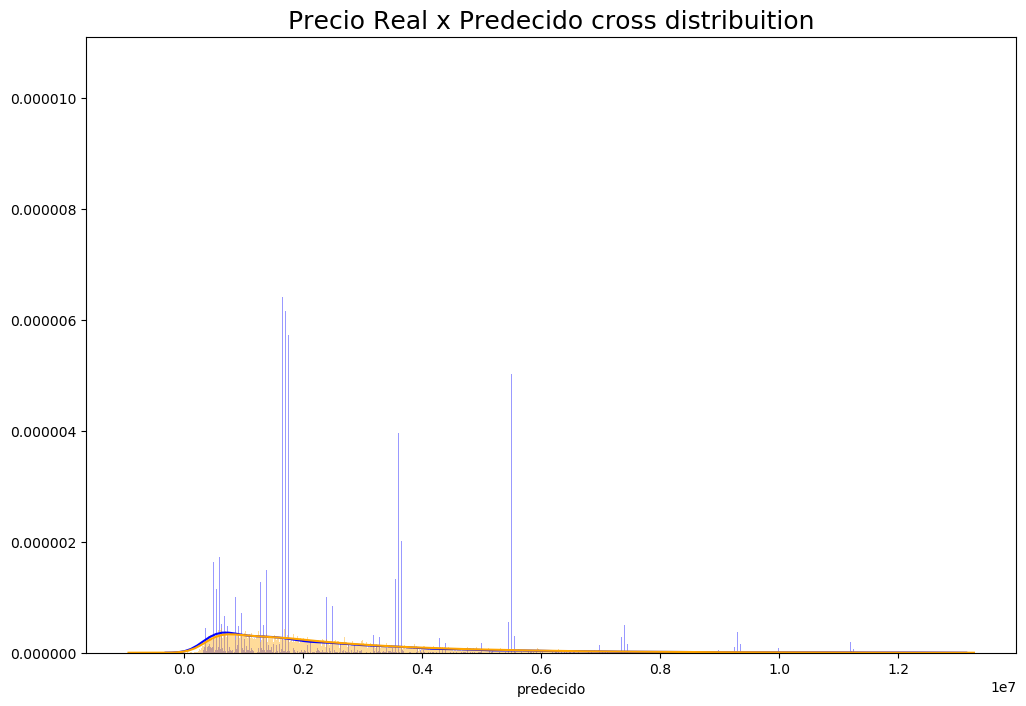

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

g = sns.distplot(a['precio'], color='blue', label='pledged (log)',bins=10000)
g = sns.distplot(a['predecido'], color='orange', label='goal (log)',bins=10000)
g.set_title("Precio Real x Predecido cross distribuition", fontsize=18)

Text(0.5, 1.0, 'Precio Real distribution')

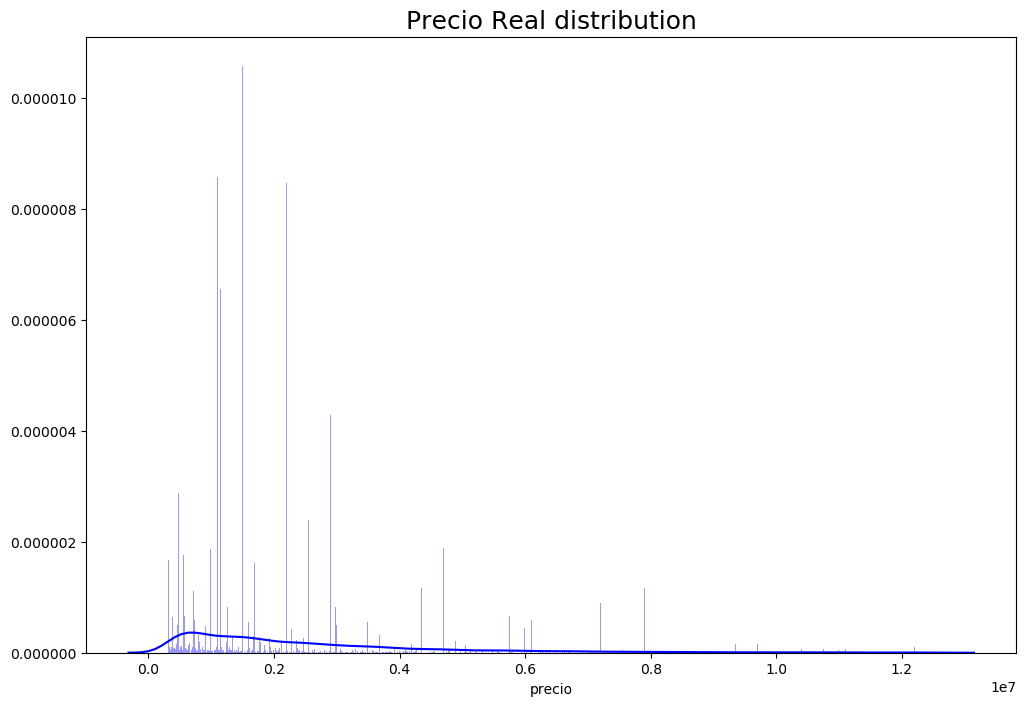

In [28]:
g = sns.distplot(a['precio'], color='blue', label='precio',bins=10000)
g.set_title("Precio Real distribution", fontsize=18)

Text(0.5, 1.0, 'Precio Predecido distribution')

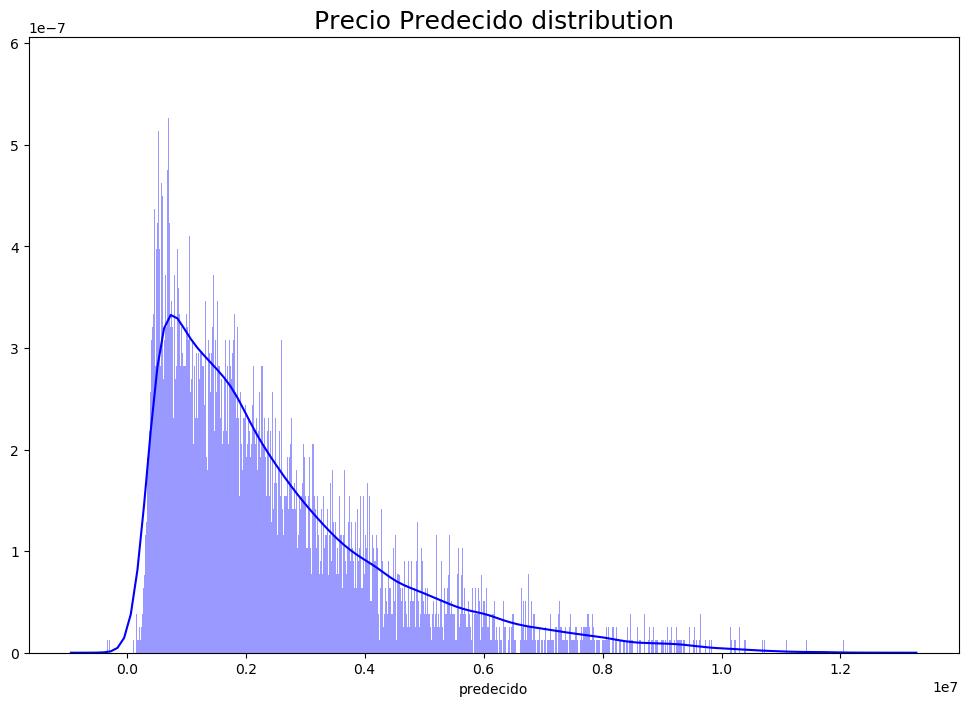

In [29]:
g = sns.distplot(a['predecido'], color='blue', label='predecido',bins=10000)
g.set_title("Precio Predecido distribution", fontsize=18)

In [ ]:
predict2 = model.predict(X_train)
b=pd.DataFrame(y_train)
a["predecido"]=0
completar(b,predict2)

In [ ]:
error(b)

In [ ]:
b.reset_index().sort_values(by="error",ascending=False)

In [2]:
## Mismoo grafico de densidad pero con el set de train, quiza para ver precios anormales

### tunnig learning_rate

In [ ]:
from sklearn.model_selection import GridSearchCV
param_test1 = {
 #'n_estimators':range(500,3501,250)   
 'learning_rate':range(0.001,0.15,0.01)
 #'max_depth':range(5,21,3),
# 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(n_estimators =1750 ,learning_rate = 0.1,min_child_weight=1 ,max_depth = 11,subsample= 0.7, colsample_bytree= 1.0,objective="reg:squarederror",eval_metric="rmse"), 
                        param_grid = param_test1,
                        n_jobs=6,
                        cv=4,
                        verbose=10)

gsearch1.fit(X_train,y_train)

gsearch1.best_params_, gsearch1.best_score_

In [ ]:
best_grid = gsearch1.best_estimator_
predecir(best_grid,X_train,y_train,X_test,y_test)

### tunnig gamma

In [ ]:
from sklearn.model_selection import GridSearchCV
param_test1 = {
 'gamma':[i/10.0 for i in range(0,10)]
    #'n_estimators':range(500,3501,250)   
 #'learning_rate':range(0.001,0.15,0.01)
 #'max_depth':range(5,21,3),
# 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(n_estimators =1750 ,scoring='roc_auc',learning_rate = 0.1,min_child_weight=1 ,max_depth = 11,subsample= 0.7, colsample_bytree= 1.0,objective="reg:squarederror",eval_metric="rmse"), 
                        param_grid = param_test1,
                        n_jobs=6,
                        cv=4,
                        verbose=10)

gsearch1.fit(X_train,y_train)

gsearch1.best_params_, gsearch1.best_score_

In [ ]:
best_grid = gsearch1.best_estimator_
predecir(best_grid,X_train,y_train,X_test,y_test)

In [ ]:
# Tuning Regularization Parameters

In [ ]:

from sklearn.model_selection import GridSearchCV
param_test1 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
 #'gamma':[i/10.0 for i in range(0,10)]
    #'n_estimators':range(500,3501,250)   
 #'learning_rate':range(0.001,0.15,0.01)
 #'max_depth':range(5,21,3),
# 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(gamma=,n_estimators = 1750 ,scoring='roc_auc',learning_rate = 0.1,min_child_weight=1 ,max_depth = 11,subsample= 0.7, colsample_bytree= 1.0,objective="reg:squarederror",eval_metric="rmse"), 
                        param_grid = param_test1,
                        n_jobs=6,
                        cv=4,
                        verbose=10)

gsearch1.fit(X_train,y_train)

gsearch1.best_params_, gsearch1.best_score_

In [ ]:
best_grid = gsearch1.best_estimator_
predecir(best_grid,X_train,y_train,X_test,y_test)